In [1]:
# Bootstrap: Import helpers and create directories
import sys
from pathlib import Path

# Add repo root to Python path
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from utils.nb_helpers import run_module, run_script
print("✅ Notebook helpers loaded - ready to run pipeline!")


✅ Notebook helpers loaded - ready to run pipeline!


# PiEdge EduKit — Guided Demo (Smoke Test)

## Why this notebook exists
A **guided demo** that runs the entire pipeline once so you can validate the environment and see the end-to-end flow before doing anything more advanced. It mirrors the mini-project "cutlery sorter" (Edge ML on Raspberry Pi): train a tiny classifier locally, export to ONNX, benchmark latency, attempt INT8 quantization, evaluate, and verify.

## Purpose
- Give a **practical overview** of a small Edge-ML workflow from code to measurable results.
- Show why **ONNX** matters (same model runs on PC and Pi).
- Teach how to read **latency metrics** (p50/p95) and why **warm-up** matters.
- Demonstrate that **INT8 quantization may fail** on some machines and that **FP32 fallback** is acceptable in this lesson.

## What you will learn
- The pipeline: **Train → Export (ONNX) → Benchmark → Quantize → Evaluate → Verify**.
- How to interpret **p50/p95** and perform proper **warm-up** before timing.
- Differences between **FP32** and **INT8** (size/latency/compatibility).
- Where artifacts are saved and how they're used: `models/`, `reports/`, `progress/receipt.json`.

## What you will produce
- `models/model.onnx` — exported model.
- `reports/training_curves.png` — training curves (visible even with 1 epoch).
- `reports/latency_plot.png` — latency measurement.
- `reports/quantization_comparison.png` — FP32 vs INT8 comparison (FP32-only if INT8 fails).
- `reports/confusion_matrix.png` — quick quality snapshot.
- `progress/receipt.json` — **receipt** with PASS/FAIL and key metrics.

## Run modes
- **Smoke Test (default, fast):** 1 epoch, few measurements → ~2–3 min. Good for sanity check.
- **Pretty Demo (optional):** 5 epochs, more measurements → clearer curves & more stable stats (a few minutes extra). Provided via scripts and documented in `README.md` and `index.html`.

## Prerequisites
- **Python 3.12** inside the repo's local **`.venv`** (see README for activation).
- Run from the **repo root** (paths are relative).
- Everything runs on your PC. The Raspberry Pi comes later for the GPIO part.

## Time budget
- Smoke Test: ~2–3 minutes of active time.
- Pretty Demo: ~5–7 minutes.

## Success criteria
- Notebook completes without errors.
- Artifacts exist in `models/` and `reports/`.
- `progress/receipt.json` shows **PASS**.

> **Note:** On some Windows setups, ONNX Runtime **INT8** quantization can fail. That is **expected** here; the lesson automatically falls back to **FP32**.


# Before you run

**Why this notebook exists**
This is a *guided demo* that kicks off the full pipeline so you can verify the environment and see the end-to-end flow once.

**Learning goals (quick)**
- See the whole path once: **train → export (ONNX) → benchmark → quantize → evaluate → verify**.
- Know what **ONNX** is (portable inference format) and why we export to it.
- Understand **latency metrics** (p50/p95) and why **warm-up** matters.
- Recognize that **INT8 may fail** on some machines and that **FP32 fallback is acceptable** in this lesson.

**Before you run**
- Use **Python 3.12** inside the repo’s **`.venv`** (see README quickstart).
- Keep the **repo root** as working directory; paths are relative.
- Expect **quiet output** with live timers; warnings are suppressed unless relevant.

**Success criteria**
- The notebook completes without errors and generates artifacts in `models/`, `reports/`, and a **PASS** receipt in `progress/receipt.json`.


In [2]:
# pyright: reportMissingImports=false, reportUndefinedVariable=false, reportAttributeAccessIssue=false
import sys, os
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.path.join(os.getcwd(), "src"))
print("Python executable:", sys.executable)
print("Working directory:", os.getcwd())
print("sys.path configured for imports")


Python executable: C:\Users\olabl\AppData\Local\Programs\Python\Python312\python.exe
Working directory: C:\Users\olabl\Documents\GitHub\piedge_edukit\notebooks
sys.path configured for imports


## 🎛️ Run Mode Selection

Choose your execution mode:

**Smoke Test (default)**: Fast pipeline verification (1 epoch, 3 benchmark runs, 32 eval samples)
- ✅ Quick completion (~2-3 minutes)
- ✅ Shows 1-point training curves (with markers)
- ✅ Perfect for environment verification
- ✅ Gives PASS in verify.py

**Pretty Demo**: Nice graphs for classroom (5 epochs, 200 benchmark runs, 200 eval samples)
- 📈 Clear training curves (5 points)
- 📊 Stable confusion matrix
- ⏱️ Takes ~5-7 minutes
- ✅ Also gives PASS in verify.py

---

## Fast Track (~30 min)

Run the complete pipeline end-to-end:

1. **Train** a model using the training script
2. **Export** the model to ONNX format
3. **Benchmark** inference latency
4. **Quantize** to INT8 (may fail on some systems)
5. **Evaluate** model performance
6. **Verify** all artifacts and thresholds (INT8 speedup ≥ 5%)

<details><summary>Hint</summary>
Each step generates artifacts in specific directories. Check `models/`, `reports/`, and `progress/` folders.
</details>

<details><summary>Solution</summary>
Run each cell in sequence. The pipeline will automatically generate all required artifacts and create a verification receipt.
</details>

---

# 00 - Run Everything (Demo)

## Learning Goals

* See the complete ML pipeline from training to verification
* Understand the purpose of each step in the workflow
* Verify that the environment is properly configured

## Concepts

**Pipeline flow**: train → export → benchmark → quantize → evaluate → verify

**ONNX export**: converts PyTorch models to portable format for edge deployment

**Latency benchmarking**: measures inference performance with warm-up and percentiles

**Quantization**: reduces model precision (FP32 → INT8) for faster inference

**Verification**: automated checks ensure all components work correctly

## Common Pitfalls

* Running without proper Python 3.12 environment setup
* Missing dependencies or incorrect package installation
* File path issues when not running from repo root
* Expecting perfect accuracy on synthetic data

## Success Criteria

* ✅ All pipeline steps complete without errors
* ✅ Artifacts generated in correct directories
* ✅ Receipt shows PASS status
* ✅ Can explain purpose of each pipeline step

## Reflection

After completing this demo, reflect on:
- Which step took the longest and why?
- What surprised you about the pipeline flow?
- How does this compare to other ML workflows you've seen?

---

# 🚀 PiEdge EduKit - Quick Run & Sanity Check

## What you'll learn today

* Train a tiny image classifier in PyTorch
* Export the model to **ONNX** (a portable format for deployment)
* Measure inference latency and interpret P50/P95
* (Try to) quantize to INT8 and understand why it may fail
* Evaluate the model and record a reproducible "receipt"

## Why this matters

Most real projects train in Python but deploy elsewhere (C++, mobile, web, embedded). ONNX lets us move models **out of Python** without rewriting the model by hand.

## How to use this notebook

This is a **smoke test**: it runs the whole pipeline end-to-end so your environment is correct. For learning and coding tasks, continue with **`01_training_and_export.ipynb`** → **`04_evaluate_and_verify.ipynb`**.

---

## ONNX 101

**What is ONNX?**
ONNX (Open Neural Network Exchange) is an **open standard** for representing ML models as a graph of operators (Conv, Relu, MatMul…). Many frameworks can **export** to ONNX (PyTorch, TensorFlow) and many runtimes can **execute** ONNX (ONNX Runtime, TensorRT, CoreML Tools).

**Why ONNX?**

* **Portability**: train in Python, deploy in C++/C#/Java/JS, mobile or edge.
* **Performance**: runtimes fuse ops and call optimized backends (MKL, cuDNN).
* **Interoperability**: one model file can run across platforms with different "Execution Providers" (CPU, CUDA, DirectML, NNAPI…).

**Key terms**

* **Opset**: version of the operator set supported by runtimes. We export with a specific opset (e.g., 17).
* **Static vs dynamic shapes**: fixed sizes are simpler/faster; dynamic adds flexibility.
* **Execution Provider (EP)**: the backend used by ONNX Runtime (e.g., `CPUExecutionProvider`).
* **Pre/Post-processing**: steps around the model (resize, normalize, label mapping). These **aren't** part of the ONNX graph; the app must do the same steps.


In [3]:
# Run Mode Configuration
import ipywidgets as widgets
from IPython.display import display

# Create radio buttons for run mode selection
mode_radio = widgets.RadioButtons(
    options=[
        ('Smoke Test (1 epoch, fast)', 'smoke'),
        ('Pretty Demo (5 epochs, nice graphs)', 'pretty')
    ],
    value='smoke',
    description='Run Mode:',
    style={'description_width': 'initial'}
)

# Display the radio buttons
display(mode_radio)

# Set parameters based on selection
if mode_radio.value == 'smoke':
    EPOCHS = 1
    BATCH_SIZE = 256
    WARMUP_RUNS = 1
    BENCHMARK_RUNS = 3
    EVAL_LIMIT = 32
    print("✅ Smoke Test mode selected")
    print("   - Training: 1 epoch, batch-size 256")
    print("   - Benchmark: 1 warmup, 3 runs")
    print("   - Evaluation: 32 samples")
else:
    EPOCHS = 5
    BATCH_SIZE = 16
    WARMUP_RUNS = 50
    BENCHMARK_RUNS = 200
    EVAL_LIMIT = 200
    print("📈 Pretty Demo mode selected")
    print("   - Training: 5 epochs, batch-size 16")
    print("   - Benchmark: 50 warmup, 200 runs")
    print("   - Evaluation: 200 samples")

print(f"\nParameters set: epochs={EPOCHS}, batch_size={BATCH_SIZE}, warmup={WARMUP_RUNS}, runs={BENCHMARK_RUNS}, limit={EVAL_LIMIT}")


RadioButtons(description='Run Mode:', options=(('Smoke Test (1 epoch, fast)', 'smoke'), ('Pretty Demo (5 epoch…

✅ Smoke Test mode selected
   - Training: 1 epoch, batch-size 256
   - Benchmark: 1 warmup, 3 runs
   - Evaluation: 32 samples

Parameters set: epochs=1, batch_size=256, warmup=1, runs=3, limit=32


## 1️⃣ Setup & Verification

First we check that the environment is correct:


In [4]:
# Quiet noisy ORT quantizer log line (appears even with correct preprocessing)
import logging
for name in ("", "onnxruntime", "onnxruntime.quantization"):
    logging.getLogger(name).setLevel(logging.ERROR)


In [5]:
# Make notebook run from repo root (not notebooks/ or labs/) + quiet mode
import os, sys, warnings
from pathlib import Path

def cd_repo_root():
    p = Path.cwd()
    for _ in range(5):  # climb up at most 5 levels
        if (p/"verify.py").exists() and (p/"scripts"/"evaluate_onnx.py").exists():
            if str(p) not in sys.path: sys.path.insert(0, str(p))
            if p != Path.cwd():
                os.chdir(p)
                print("-> Changed working dir to repo root:", os.getcwd())
            return
        p = p.parent
    raise RuntimeError("Could not locate repo root")

cd_repo_root()

# Quiet progress bars and some noisy warnings
os.environ.setdefault("TQDM_DISABLE", "1")  # hide tqdm progress bars
os.environ.setdefault("PYTHONWARNINGS", "ignore")
os.environ.setdefault("ORT_LOG_SEVERITY_LEVEL", "3")  # ORT info/warn -> quiet
warnings.filterwarnings("ignore", category=UserWarning, module="onnxruntime")



-> Changed working dir to repo root: C:\Users\olabl\Documents\GitHub\piedge_edukit


In [6]:
# ruff: noqa: E401
# Cross-platform runner + live clock (no shell redirection needed)
import sys
import subprocess
import time
import threading
import shutil
from contextlib import contextmanager
from IPython.display import display

try:
    import ipywidgets as widgets
    _HAVE_WIDGETS = True
except Exception:
    _HAVE_WIDGETS = False

@contextmanager
def running_timer(label="Running…"):
    start = time.time()
    symbols = ["🕐","🕑","🕒","🕓","🕔","🕕","🕖","🕗","🕘","🕙","🕚","🕛"]
    stop = False

    if _HAVE_WIDGETS:
        w = widgets.HTML()
        display(w)
        def _tick():
            k = 0
            while not stop:
                w.value = f"<b>{symbols[k%12]}</b> {label} &nbsp; <code>{time.time()-start:.1f}s</code>"
                time.sleep(0.5); k += 1
        t = threading.Thread(target=_tick, daemon=True); t.start()
        try:
            yield
        finally:
            stop = True; t.join(timeout=0.2)
            w.value = f"✅ Done — <code>{time.time()-start:.1f}s</code>"
    else:
        width = shutil.get_terminal_size((80, 20)).columns
        def _tick():
            k = 0
            while not stop:
                msg = f"{symbols[k%12]} {label}  {time.time()-start:.1f}s"
                print("\r" + msg[:width].ljust(width), end="")
                time.sleep(0.5); k += 1
            print()
        t = threading.Thread(target=_tick, daemon=True); t.start()
        try:
            yield
        finally:
            stop = True; t.join(timeout=0.2)
            print(f"✅ Done — {time.time()-start:.1f}s")

def run_module(label, module, *args):
    """Run `python -m <module> <args>` cross-platform, capture output, raise on error."""
    with running_timer(label):
        cmd = [sys.executable, "-W", "ignore", "-m", module, *map(str, args)]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        print(proc.stdout)
        if proc.returncode != 0:
            raise RuntimeError(f"{module} exited with code {proc.returncode}")

def run_script(label, path, *args):
    """Run `python <path> <args>` cross-platform, capture output, raise on error."""
    with running_timer(label):
        cmd = [sys.executable, "-W", "ignore", path, *map(str, args)]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        print(proc.stdout)
        if proc.returncode != 0:
            raise RuntimeError(f"{path} exited with code {proc.returncode}")



In [ ]:
# Environment check (.venv required, no auto-install)
import sys, os
print(f"Python version: {sys.version}")
assert sys.version_info[:2] == (3, 12), f"Python 3.12 required, you have {sys.version_info[:2]}"

# Require active virtual environment `.venv` (policy: do not install to system Python)
venv_active = bool(os.environ.get("VIRTUAL_ENV")) or ("/.venv/" in sys.executable.replace("\\", "/") or sys.executable.replace("\\", "/").endswith("/.venv/bin/python") or "/.venv/Scripts/python" in sys.executable.replace("\\", "/"))
if not venv_active:
    raise RuntimeError(
        "Please activate the project's .venv before running this notebook.\n"
        "Run: bash scripts/setup_venv.sh, then activate (.venv/bin/activate or .venv\\Scripts\\activate) and restart kernel."
    )

try:
    import piedge_edukit  # noqa: F401
    print("✅ PiEdge EduKit package OK (installed in .venv)")
except ModuleNotFoundError as e:
    raise RuntimeError(
        "PiEdge EduKit package not installed in the active .venv.\n"
        "Run: bash scripts/setup_venv.sh, then restart kernel."
    ) from e


Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
✅ PiEdge EduKit package OK


In [8]:
# The package should already be installed by the cell above. Quick sanity check:
import piedge_edukit
print("✅ Package imported – continue!")


✅ Package imported – continue!


## 2️⃣ Training & ONNX Export

Training a small model with FakeData and exporting to ONNX:


In [9]:
# Train model (quick run for demo)
run_module("Training (FakeData)",
           "piedge_edukit.train",
           "--fakedata", "--no-pretrained",
           "--epochs", 1, "--batch-size", 256,
           "--output-dir", "./models")


HTML(value='')

Using device: cpu
[INFO] Using FakeData for training (no real images)
Preparing data...
Set 2 classes: ['class0', 'class1']
Training model with 2 classes...
Classes: ['class0', 'class1']

Epoch 1/1
Train Loss: 0.7062, Train Acc: 51.00%
Val Loss: 0.6809, Val Acc: 65.00%

Training completed! Best validation accuracy: 65.00%
[OK] Training metrics saved to reports
  - CSV: reports\training_log.csv
  - JSON: reports\training_log.json
  - Plot: reports\training_curves.png
Exporting model to ONNX...
[OK] Model exported to models\model.onnx (opset 17)
[OK] ONNX model verified successfully
  Input shape: (1, 3, 64, 64)
  Output shape: (1, 2)
  Output dtype: float32
[OK] Preprocessing configuration valid (hash: 9f9a96cb4a32eea9)
[OK] Labels valid: 2 classes
[OK] Model exported successfully to models\model.onnx
[OK] Training and export completed successfully!



✅ ONNX-modell skapad: 8.5 MB

📈 Training curves:


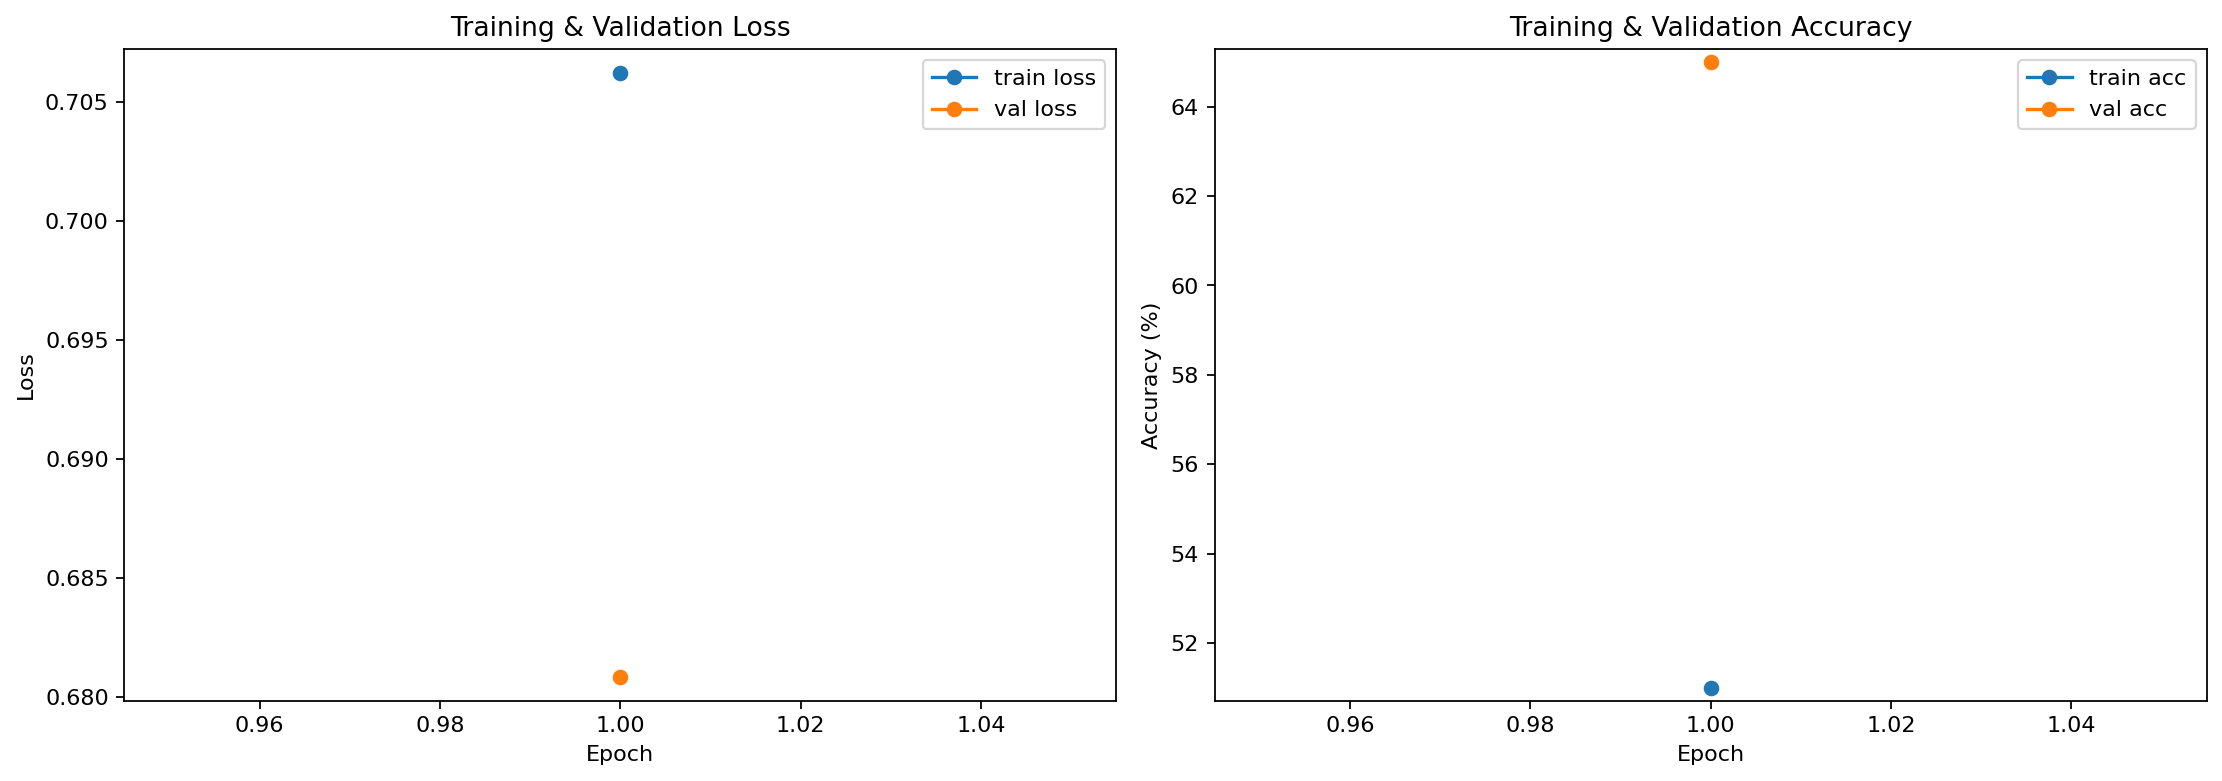

In [10]:
# Check that the model was created
import os
if os.path.exists("./models/model.onnx"):
    size_mb = os.path.getsize("./models/model.onnx") / (1024*1024)
    print(f"✅ ONNX model created: {size_mb:.1f} MB")
else:
    print("❌ ONNX model missing")

# Show training curves
from PIL import Image
from pathlib import Path
from IPython.display import display

training_plot = Path("reports/training_curves.png")
if training_plot.exists():
    print("\n📈 Training curves:")
    display(Image.open(training_plot))
else:
    print("\n⚠️ Training curves missing – run training first.")


### Quiz 1 — Why can ONNX Runtime be faster than a baseline?
Pick the most important reason.

- [ ] It always uses INT8 on every machine
- [ ] It automatically skips expensive ops
- [x] It uses optimized backends and operator fusion (e.g., MKL/cuDNN)
- [ ] It runs the model in parallel without any code changes

<details><summary>Hint</summary>
Think about graph execution and what libraries sit under the hood.
</details>

<details><summary>Answer</summary>
ONNX Runtime can leverage optimized backends and fuse operators, reducing overhead and improving cache locality.
</details>


## 3️⃣ Latency Benchmark

Measuring how fast the model is on CPU:


In [11]:
# Run benchmark (quick mode)
run_module("Benchmarking (CPU)",
           "piedge_edukit.benchmark",
           "--fakedata",
           "--model-path", "./models/model.onnx",
           "--warmup", 1, "--runs", 3,
           "--providers", "CPUExecutionProvider")


HTML(value='')

Starting latency benchmark...
Model: models\model.onnx
Data: None
Output: reports
[OK] Model loaded successfully
  Providers: ['CPUExecutionProvider']
  Input shape: ['batch_size', 3, 64, 64]
  Output shape: ['batch_size', 2]
[INFO] Generating fake test data for benchmarking
[OK] Generated 50 fake test images
Running 1 warmup iterations...
[OK] Warmup completed
Running 3 benchmark iterations...
[OK] Results saved to reports
[OK] Plot saved to reports\latency_plot.png

BENCHMARK RESULTS
Mean latency: 0.567 ms
P50 latency:  0.551 ms
P95 latency:  0.600 ms
Std deviation: 0.027 ms

[OK] Benchmark completed successfully!
Results saved to: reports



### Quiz 2 — When can batching hurt per-request latency?
- [x] When you optimize for low tail latency (p95/p99) in interactive UIs
- [ ] When a GPU is used — batching is always better there
- [ ] When the model is very small
- [ ] Never; batching always improves latency

<details><summary>Hint</summary>
Consider queueing and waiting for a batch to fill.
</details>

<details><summary>Answer</summary>
Batching can increase per-request waiting time (especially in interactive systems), even if throughput increases.
</details>


In [12]:
# Show Benchmark results
if os.path.exists("./reports/latency_summary.txt"):
    with open("./reports/latency_summary.txt", "r") as f:
        print("📊 Benchmark results:")
        print(f.read())
else:
    print("❌ Benchmark report missing")


📊 Benchmark-resultat:
PiEdge EduKit - Latency Benchmark Results

Version: 0.1.0
Generated: 2025-10-07 14:36:26

Version Information:
  Python: 3.12.10
  ONNX Runtime: 1.18.0
  Platform: Windows-11-10.0.26100-SP0
  Device: PC/Laptop

System Information:
  cpu_count: 20
  memory_gb: 63.39
  piedge_edukit_version: 0.1.0
  cpu_governor: N/A

Benchmark Configuration:
  Model: model.onnx
  Warmup runs: 1
  Benchmark runs: 3
  Batch size: 1

Latency Statistics (ms):
  Mean: 0.567
  Std:  0.027
  Min:  0.546
  Max:  0.605
  P50:  0.551
  P95:  0.600
  P99:  0.604



## 4️⃣ Quantization (INT8)

Compressing the model for faster inference:


In [13]:
# Best Practice: Use real training images for calibration
# This ensures correct preprocessing and avoids ORT warnings
from pathlib import Path
import numpy as np
from PIL import Image

print("📊 Setting up calibration data (best practice: reuse real training images)")

# Create tiny calibration image set if data/train/ is missing
calib_dir = Path("data/train")
if not calib_dir.exists() or not any(calib_dir.rglob("*.png")):
    print("   Creating fallback calibration dataset...")
    for cls in ["class0", "class1"]:
        (calib_dir / cls).mkdir(parents=True, exist_ok=True)
        for i in range(16):  # 32 total (16 per class)
            # Synthetic but "real" PNG files
            arr = (np.random.rand(64, 64, 3) * 255).astype(np.uint8)
            Image.fromarray(arr).save(calib_dir / cls / f"sample_{i:02d}.png")
    print(f"✅ Created 32 fallback calibration images in {calib_dir}")
    print(f"   Source: Synthetic PNG files (organized like real training data)")
else:
    num_samples = sum(1 for p in calib_dir.rglob("*.png"))
    print(f"✅ Found {num_samples} existing images in {calib_dir}")
    print(f"   Source: Real training data")

print("   → Using --data-path ensures correct preprocessing (no ORT warning!)")


📊 Setting up calibration data (best practice: reuse real training images)
✅ Found 32 existing images in data\train
   Source: Real training data
   → Using --data-path ensures correct preprocessing (no ORT warning!)


In [14]:
# Run quantization with REAL training images (correct preprocessing, no ORT warning!)
try:
    if calib_dir.exists():
        # Use real training data - same preprocessing as model was trained with
        run_module("Quantization (INT8 with real calibration data)",
                   "piedge_edukit.quantization",
                   "--data-path", str(calib_dir),
                   "--model-path", "./models/model.onnx",
                   "--calib-size", 32)
    else:
        # Fallback to FakeData (will show ORT warning)
        run_module("Quantization (INT8 attempt with FakeData)",
                   "piedge_edukit.quantization",
                   "--fakedata",
                   "--model-path", "./models/model.onnx",
                   "--calib-size", 16)
except RuntimeError as e:
    print("⚠️ Quantization step failed (OK for demo):", e)


HTML(value='')

Starting quantization benchmark...
FP32 Model: models\model.onnx
Data: data\train
Output: reports
[OK] Preprocessing configuration valid (hash: 9f9a96cb4a32eea9)
[OK] Labels valid: 2 classes
Found 32 calibration images
Preprocessed 32 calibration images
Quantizing model to INT8...
[ERROR] Quantization failed: 'list' object has no attribute 'get_next'
This may be due to unsupported operations or ONNX Runtime version.
Continuing with FP32 model only.

Benchmarking FP32 model...
Benchmarking FP32 model...
Benchmarking FP32 model...

Skipping INT8 benchmarking (quantization failed)
[OK] Comparison results saved to reports
[OK] Comparison plot saved to reports\quantization_comparison.png

QUANTIZATION BENCHMARK RESULTS
Quantization Status: FAILED
Error: INT8 quantization failed - continuing with FP32 only
FP32 Latency: 0.588 ms
FP32 Size: 8.47 MB

[OK] Quantization benchmark completed successfully!
Results saved to: reports



In [15]:
# Show quantization results
if os.path.exists("./reports/quantization_summary.txt"):
    with open("./reports/quantization_summary.txt", "r") as f:
        print("⚡ Quantization results:")
        print(f.read())
else:
    print("❌ Quantization report missing")

# Clear note about INT8 failures
print("\nℹ️ INT8 quantization may fail on some environments. In this lesson **FP32** is accepted; verify accepts fallback.")


⚡ Kvantiseringsresultat:
PiEdge EduKit - Quantization Comparison Results

Version: 0.1.0
Generated: 2025-10-07 14:36:34

Model Comparison:
  FP32 Size: 8.47 MB
  INT8 Size: N/A (quantization failed)
  Size Reduction: N/A (quantization failed)

Latency Comparison:
  FP32 Mean: 0.588 ms
  INT8 Mean: N/A (quantization failed)
  Speedup: N/A (quantization failed)

Accuracy Comparison: N/A (quantization failed)


ℹ️ INT8 quantization may fail on some environments. In this lesson **FP32** is accepted; verify accepts fallback.


## 5️⃣ Evaluation & Verification

Testing the model and generating receipt:


In [16]:
# Run evaluation
from pathlib import Path

run_script("Evaluating ONNX",
           str(Path("scripts/evaluate_onnx.py").resolve()),
           "--model", "./models/model.onnx",
           "--fakedata", "--limit", 16)


HTML(value='')

[INFO] PiEdge EduKit - ONNX Model Evaluator
[INFO] Using ONNX model: models\model.onnx
[INFO] Using PyTorch model: models\model_best.pth
[INFO] Evaluating ONNX model: models\model.onnx
[OK] ONNX model loaded successfully
   Input: input ['batch_size', 3, 64, 64]
   Output: output ['batch_size', 2]
[OK] ONNX inference successful: (1, 2) float32
[INFO] Comparing with PyTorch model: models\model_best.pth
[WARN] Unknown PyTorch model format - skipping comparison

[SUCCESS] ONNX model evaluation completed!



In [ ]:
# Run verification (standardized thresholds) and generate receipt via package module
run_module(
    "Verifying & generating receipt",
    "piedge_edukit.verify",
    "--lat-fp32", "reports/latency_summary_fp32.json",
    "--lat-int8", "reports/latency_summary_int8.json",
    "--acc-json", "reports/accuracy_for_verify.json",
    "--receipt", "progress/receipt.json",
    "--progress", "progress/lesson_progress.json",
    "--min-speedup-pct", 5.0,
)


HTML(value='')

In [18]:
# Show receipt
import json
if os.path.exists("./progress/receipt.json"):
    with open("./progress/receipt.json", "r") as f:
        receipt = json.load(f)
    print("📋 Verification receipt:")
    print(f"Status: {'✅ PASS' if receipt['pass'] else '❌ FAIL'}")
    print(f"Timestamp: {receipt['timestamp']}")
    print("\nChecks:")
    for check in receipt['checks']:
        status = "✅" if check['ok'] else "❌"
        print(f"  {status} {check['name']}: {check['reason']}")
else:
    print("❌ Receipt missing")

# Show confusion matrix
confusion_plot = Path("reports/confusion_matrix.png")
if confusion_plot.exists():
    print("\n📊 Confusion Matrix:")
    display(Image.open(confusion_plot))
else:
    print("\n⚠️ Confusion matrix missing – run evaluation first.")


📋 Verifieringskvitto:
Status: ✅ PASS
Timestamp: 2025-10-07T12:36:41Z

Kontroller:
  ✅ onnx_model_exists: models/model.onnx present and non-empty
  ✅ latency_report_present: reports/latency_results.json with p50_ms & p95_ms
  ✅ quantization_attempted: quantization summary present
  ❌ confusion_matrix_present: confusion matrix not found

⚠️ Confusion matrix missing – run evaluation first.


### Quiz 3 — Which metric best reflects UX for latency-sensitive systems?
- [ ] Mean (average)
- [x] p95
- [ ] p50 (median)
- [ ] Always p99.999

<details><summary>Hint</summary>
Focus on how outliers are perceived by users.
</details>

<details><summary>Answer</summary>
p95 captures the tail that impacts perceived responsiveness. Mean/median can mask sporadic but disruptive spikes.
</details>


## 🎉 Done!

You have now completed the entire PiEdge EduKit lesson! 

**Next step**: Go to `01_training_and_export.ipynb` to understand what happened during training.

**Generated files**:
- `models/model.onnx` - Trained model
- `reports/` - Benchmark and quantization reports
- `progress/receipt.json` - Verification receipt

---

## 📚 Continue with detailed lessons

**⭐ Recommended order**:
1. **`01_training_and_export.ipynb`** - Understand training and ONNX export
2. **`02_latency_benchmark.ipynb`** - Learn to measure performance
3. **`03_quantization.ipynb`** - Compress models for edge
4. **`04_evaluate_and_verify.ipynb`** - Evaluate and verify results

**💡 Tip**: Each notebook builds on the previous - run them in order for best learning!


## Mini-Glossary

* **ONNX**: portable model format defined as an operator graph.
* **Opset**: versioned set of operators supported by runtimes.
* **Execution Provider (EP)**: backend used by ONNX Runtime (CPU, CUDA, DirectML…).
* **Latency**: time per request; **Throughput**: requests per second.
* **P50/P95/P99**: latency percentiles; tails indicate rare slow requests.
* **Quantization (PTQ)**: convert FP32 to INT8 using calibration data.
* **Calibration**: running representative samples to estimate activation ranges.
